# HDS5210 Final

This final examination is similar in scale to the midterm from several weeks ago, but covers the scope of the entire semester.  The final also attempts to create a real-world scenario that you might encounter as a data scientist is the field.  Our goal with this final is to compile the data required to be able to understand any possible relationship between population, population density, and the spread of the COVID-19 coronavirus.  As in may real world cases, all of the data you need to do this analysis is not in one place, nicely formatted and compiled for you.  Through the final, you'll collect data from multiple sources and build your analytic dataset in a process that is documented, automated, and reproducable.

<img style='float:right' width='480px' src='https://www.lucidchart.com/publicSegments/view/095390af-7150-4dae-ac06-b98f10463cc7/image.png'>

The data you need for this final is all publicly available and real data.  The three data sources that you are reuquired to use are described in the list below and in the relationship diagram to the right.

* **Corona Virus Testing and Death Reports** - A MySQL database table that I loaded data into from the JSON file below.

 `https://coronadatascraper.com/timeseries.json`

 `corona_counts`
 
* **Location Metadata** -- A JSON file from the Corona Data Scrapper project that has a mapping of location identifiers to the location information.

 `https://coronadatascraper.com/locations.json`

* **Census Information** - Information available on Wikipedia about the population and geographic size of the counties in Missouri. 

 `https://en.wikipedia.org/wiki/List_of_counties_in_Missouri`

*Note that ALL of the data above is real data.  We'll be doing some analysis that is not necessarily standard for epidemiological studies, but should be interesting nonetheless.*

You will be asked to solve a number of different problems using this data.  As in previous assignments, there will be `assert()` statements to help you validate your work along the way.  We'll try to use old enough data so that the numbers shouldn't be changing, but it's possible that some of the data we use will be restated.


In [1]:
CORONA_COUNTS = 'corona_counts'
LOCATION_INFO = 'https://coronadatascraper.com/locations.json'
CENSUS_INFO = 'https://en.wikipedia.org/wiki/List_of_counties_in_Missouri'

# PART 1 - Get information about Missouri Counties

The **Corona Virus Testing and Death Reports** data is all in one place thanks to the work of the Corona Data Scraper project.  However, the data uses its own internal coding system to number the locations and the only reference data they have simply links those locations to [FIPS](https://en.wikipedia.org/wiki/FIPS_county_code) codes for US Counties.  Not very helpful.

Therefore, our first step will be to find somewhere that lists the FIPS code for every county in Missouri.  Thank you Wikipedia!  In fact, not only does our source have a mapping from FIPS code to county name, but it also has the population and physical area data that we also want.  So, let's start by retrieving that data from the HTML table on the ["List of counties in Missouri"](https://en.wikipedia.org/wiki/List_of_counties_in_Missouri) page.

Create a function named `get_mo_counties()` that pulls the information from this table and returns a dictionary keyed off the FIPS code and contains an entry for each of the attributes in the table.  Keep at least the elements we need: FIPS code, County, Population, Area as shown in the example below:

```
{ '001':
  { 'county': 'Adair County',
    'population': 25607,
    'area': 568
  },
  '002':
  { 'county': 'Andrew County',
    'population': 17291,
    'area': 435
  },
...
```

### TIPS

1. If you want to take a number and format it with leading 0s, this works: `"{:03d}".format(1)`

2. The Area column in this table uses a "non-breaking space" character between the number part and the "sq mi" part.  This is different than just the space bar.  If you want to tell Python to look for a non-breaking space, you can type `\xa0`

In [2]:
import pandas as pd
import requests
import json
from bs4 import BeautifulSoup

In [3]:
import pandas as pd

def get_mo_counties(url=CENSUS_INFO):
    """ (html_Json) -> dict
    This function will look throught the jason file from the census URL site and return a 
    dictionaty of the census information. The default file is the CENSUS_INFO file.
    """
    import requests
    import json
    from bs4 import BeautifulSoup
    output = {}
    
    ### YOUR CODE
    dfs = pd.read_html(url)                 #reading url file
    df = dfs[1]                             #showing the table in the data frame
    df = df.to_dict('index')                #convertin the dataframe to a dictionary
    for subject, info in df.items():        #iterating through the items and placing the information
        FIPS = info["FIPS code[7]"]         #in the dictionary that we want
        County = info["County"]
        Population = info['Population[6]']
        Area = info['Area[8]'].split('\xa0')[0].replace(',', '')
        output["{:03d}".format(FIPS)] = { "county": County, "population": Population, "area" : float(Area)}
    return output


In [4]:
get_mo_counties() # showing information in the dictionary

{'001': {'county': 'Adair County', 'population': 25607, 'area': 568.0},
 '003': {'county': 'Andrew County', 'population': 17291, 'area': 435.0},
 '005': {'county': 'Atchison County', 'population': 5685, 'area': 545.0},
 '007': {'county': 'Audrain County', 'population': 25529, 'area': 693.0},
 '009': {'county': 'Barry County', 'population': 35597, 'area': 779.0},
 '011': {'county': 'Barton County', 'population': 12402, 'area': 594.0},
 '013': {'county': 'Bates County', 'population': 17049, 'area': 848.0},
 '015': {'county': 'Benton County', 'population': 19056, 'area': 706.0},
 '017': {'county': 'Bollinger County', 'population': 12363, 'area': 621.0},
 '019': {'county': 'Boone County', 'population': 162642, 'area': 685.0},
 '021': {'county': 'Buchanan County', 'population': 89201, 'area': 410.0},
 '023': {'county': 'Butler County', 'population': 42794, 'area': 698.0},
 '025': {'county': 'Caldwell County', 'population': 9424, 'area': 429.0},
 '027': {'county': 'Callaway County', 'populat

In [5]:
mo_counties = get_mo_counties()
assert(len(mo_counties) == 115)
assert(mo_counties.get('001').get('county') == 'Adair County')
assert(mo_counties.get('007').get('population') == 25529)
assert(mo_counties.get('011').get('area') == 594)

# PART 2 - Create a List of Missouri Counties from the Corona Data Scraper Locations File

Browse the **Location Metadata** JSON file on the website and you'll see that it is a list that contains a dictionary object for each of the locations for which this website has data.  Create a Python function called `get_mo_locations()` to read that JSON file from the URL provided above and transform that JSON into a simple dictionary that has only those locations that are in Missouri.  We're going to use this dictionary to filter the actual testing and death data file during the next step.  For the structure of that dictionary, it will be most useful if you has the position of the original list entry as the dictionary key and the county's FIPS code as the dictionary value.  The reason for this is that the location identifier in the testing and death data file is the index position for the appropriate location metadata in this file.

You'll notice that the FIPS code from this file includes a 2-digit prefix that has the state code of `29` on it.  You'll need to remove that and only keep the last three characters of the FIPS code so that it matches the three digit FIPS code from the Wikipedia page above.

The output returned from your `get_mo_locations()` function should look like the sample below and ONLY contain **the counties from Missouri**.

```
{1901: '001',
 1902: '003',
 1903: '005',
 1904: '007',
 1905: '009',
 1906: '011',
...
```


In [6]:
import pandas as pd
import requests
import json

def get_mo_locations(url=LOCATION_INFO):
    """ (html_Json) -> dict
    This function will look throught the jason file from the location URL site and return a 
    dictionaty of the location numbers to get the FIP number of the county. 
    The default file is the LOCATION_INFO file.
    """
    output = {}
    
    ### YOUR CODE
    content = requests.get(url)                    #request data from URL
    config = json.loads(content.content)           #load JSON file
    config[0]
    num = 0
    for state in config:
        if state.get('state') == 'Missouri' and num < 3427: #in the JSON after 3427, it is just the population for the state as a whole not just counties
            index = num
            fip = state.get('featureId')[7:]     #iterate through the file and get those that the state equals
            output.setdefault(index)             #missouri.  Look for the featureID which is where the FIP number is
            output[index] = fip                  #remove the firt 6 characters from the string to get the FIP#
            num+=1
        else:
            num+=1      
    return output

In [7]:
print(len(get_mo_locations()))
get_mo_locations()

115


{1903: '001',
 1904: '003',
 1905: '005',
 1906: '007',
 1907: '009',
 1908: '011',
 1909: '013',
 1910: '015',
 1911: '017',
 1912: '019',
 1913: '021',
 1914: '023',
 1915: '025',
 1916: '027',
 1917: '029',
 1918: '031',
 1919: '033',
 1920: '035',
 1921: '037',
 1922: '039',
 1923: '041',
 1924: '043',
 1925: '045',
 1926: '047',
 1927: '049',
 1928: '051',
 1929: '053',
 1930: '055',
 1931: '057',
 1932: '059',
 1933: '061',
 1934: '063',
 1935: '065',
 1936: '067',
 1937: '069',
 1938: '071',
 1939: '073',
 1940: '075',
 1941: '077',
 1942: '079',
 1943: '081',
 1944: '083',
 1945: '085',
 1946: '087',
 1947: '089',
 1948: '091',
 1949: '093',
 1950: '095',
 1951: '097',
 1952: '099',
 1953: '101',
 1954: '103',
 1955: '105',
 1956: '107',
 1957: '109',
 1958: '111',
 1959: '113',
 1960: '115',
 1961: '117',
 1962: '119',
 1963: '121',
 1964: '123',
 1965: '125',
 1966: '127',
 1967: '129',
 1968: '131',
 1969: '133',
 1970: '135',
 1971: '137',
 1972: '139',
 1973: '141',
 1974:

In [8]:
mo_locations = get_mo_locations()
assert(len(mo_locations) == 115)
assert(mo_locations.get(1903) == '001') #the county number changed again to 1903

# PART 3 - Corona Virus Cases for Missouri Counties

Next, we're going to use the data available in the **Corona Virus Testing and Death Reports** data in the MySQL **corona_counts** table.  This data will need to be filtered down to only contain the information for Missouri Counties.

Create a function called `get_corona_counts()` that retrieves retrieves information from the same MySQL database we used before.  I've provided the connection information for your convenience.  Your function will need to make the database connect and retrieve the data from the **corona_counts** table.  It should use the output from the `get_mo_locations()` function to filter the information in the table and return a dataframe with only the data for Missouri counties.

In [9]:
# Then, this code will automatically setup your 
import os
from sqlalchemy import create_engine
import pandas as pd

host = 'slucor2020.cgdcoitnku0k.us-east-1.rds.amazonaws.com'
port = '3306'
user = 'slucor2020'

password = 'SLUcor2020'
database = 'hds5210'

conn = create_engine('mysql+pymysql://' + 
                     user + ':' + 
                     password + '@' + 
                     host + ':' + 
                     str(port) + '/' + 
                     database)

In [10]:
import getpass                                                       #this is just showing some of the work 
output = pd.DataFrame()                                              #I did to get to the function.
c_counts = pd.read_sql_query('SELECT * FROM ' + CORONA_COUNTS, conn)
mo = c_counts['location'].isin(get_mo_locations())
mo_corona = c_counts[mo]
print(mo_corona['dt'].value_counts().mean())
print(mo_corona['location'].value_counts().mean())
print('dt' in mo_corona.columns)
print('location' in mo_corona.columns)
print('cases' in mo_corona.columns)
mo_corona.head(100)

115.0
100.0
True
True
True


,idx,dt,location,cases,deaths,hospitalized,discharged
1903,1903,2020-01-22,1903,0.0,0.0,NaN,NaN
1904,1904,2020-01-22,1904,0.0,0.0,NaN,NaN
1905,1905,2020-01-22,1905,0.0,0.0,NaN,NaN
1906,1906,2020-01-22,1906,0.0,0.0,NaN,NaN
1907,1907,2020-01-22,1907,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...
1998,1998,2020-01-22,1998,0.0,0.0,NaN,NaN
1999,1999,2020-01-22,1999,0.0,0.0,NaN,NaN
2000,2000,2020-01-22,2000,0.0,0.0,NaN,NaN
2001,2001,2020-01-22,2001,0.0,0.0,NaN,NaN


In [11]:
def get_corona_counts(locations, conn, table=CORONA_COUNTS):
    """ (fxn(locations), conn(database), sql_table) -> dict
    This function will look throught the data information from the same MySQL database. it returns a 
    dataframe with only the data for Missouri counties.
    """
    output = pd.DataFrame()
    
    ### YOUR CODE
    c_counts = pd.read_sql_query('SELECT * FROM ' + CORONA_COUNTS, conn) #reading the MySQL database

    mo = c_counts['location'].isin(get_mo_locations())   #filtering the information from get_mo_locations is
                                                         #also in the SQL dataframe. 
    output = c_counts[mo]                                #outputing only the mo data
    return output

In [12]:
get_corona_counts(get_mo_locations(), conn) #looking at the data


,idx,dt,location,cases,deaths,hospitalized,discharged
1903,1903,2020-01-22,1903,0.0,0.0,NaN,NaN
1904,1904,2020-01-22,1904,0.0,0.0,NaN,NaN
1905,1905,2020-01-22,1905,0.0,0.0,NaN,NaN
1906,1906,2020-01-22,1906,0.0,0.0,NaN,NaN
1907,1907,2020-01-22,1907,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...
397882,397882,2020-04-30,2013,1.0,0.0,NaN,NaN
397883,397883,2020-04-30,2014,9.0,0.0,NaN,NaN
397884,397884,2020-04-30,2015,1077.0,57.0,NaN,NaN
397885,397885,2020-04-30,2016,1.0,NaN,NaN,NaN


In [13]:
mo_corona = get_corona_counts(get_mo_locations(), conn)
assert(mo_corona['dt'].value_counts().mean() == 115)
assert(mo_corona['location'].value_counts().mean() == 100)
assert('dt' in mo_corona.columns)
assert('location' in mo_corona.columns)
assert('cases' in mo_corona.columns)

## PART 4 - Calculate Doubling Time between 3/1 and 3/31

The next step in our process is to calculate the doubling time for each county.  [Doubling time](https://en.wikipedia.org/wiki/Doubling_time) is calculated by computing:

```
doubling_time = ln(2) / growth_rate
```

where growth rate is calculated by:

```
growth_rate = ln(N(t) / N(0)) / t

N(t) = number at time t
N(0) = number at start time
t    = number of time units (we'll use days)
```

In this part, you should create a function called `calc_doubling_rate()` that takes the dataframe output from your `get_corona_counts()` function and returns four Series (columns): location, cases on start date, cases on end date, and the doubling rate calculated based start and end date that you provide.  You can assume start and end date are strings in the format YYYY-MM-DD.

Special rules:
* If the count at the start or the end is 0 then the doubling_time should be NaN
* If the count on the end date is less than the count on the start date, then the doubling_time should be NaN

Once we have a data frame with only one row per county, we can merge that in with the census information from step 1 and start looking at some relationships.



### TIPS

1. You'll need to calculate some natural logs as shown above.  The way to do that with Pandas requires **`import numpy as np`** and then something like **`np.log2(df['cases'])`**

2. The right way to overwrite some of the rows under a particular column is by using he df.loc(row_indexer, col_indexer) syntax.  For instance, if you have a filter called `my_filter`, then updating the doubling_time column would look like this:  `output.loc[my_filter, 'my_column'] = np.nan`

In [14]:
import datetime
from datetime import timedelta               #this is the work I did to look at the data and reformat the information
                                             
import numpy as np
datetimeFormat = '%Y-%m-%d'

data = mo_corona

start_date = '2020-04-01'
end_date = '2020-04-20'
data = data[(data['dt'] == start_date ) | (data['dt'] == end_date)]
data = data.drop(['hospitalized', 'discharged','deaths', 'idx'], axis = 1)
print(data)
data = data.pivot(index = 'location', columns = 'dt', values = 'cases').reset_index()
data.columns = ['location', 'start', 'end']
data.head()

                dt  location  cases
270243  2020-04-01      1903    1.0
270244  2020-04-01      1904    0.0
270245  2020-04-01      1905    1.0
270246  2020-04-01      1906    0.0
270247  2020-04-01      1907    2.0
...            ...       ...    ...
353368  2020-04-20      2013    1.0
353369  2020-04-20      2014    9.0
353370  2020-04-20      2015  859.0
353371  2020-04-20      2016    1.0
353372  2020-04-20      2017    0.0

[230 rows x 3 columns]


,location,start,end
0,1903,1.0,2.0
1,1904,0.0,1.0
2,1905,1.0,4.0
3,1906,0.0,0.0
4,1907,2.0,6.0


In [15]:
N_t = data['end']
N_0 = data['start']
t  = datetime.datetime.strptime(end_date, datetimeFormat)\
    - datetime.datetime.strptime(start_date, datetimeFormat)
t = t.days
growth_rate = np.log(N_t/N_0)/ t
data['doubling_time'] = np.log(2)/growth_rate 

data.head(6)

,location,start,end,doubling_time
0,1903,1.0,2.0,19.000000
1,1904,0.0,1.0,0.000000
2,1905,1.0,4.0,9.500000
3,1906,0.0,0.0,NaN
4,1907,2.0,6.0,11.987665
5,1908,3.0,3.0,inf


In [16]:
filter1 = data.start == 0
filter2 = data.start > data.end
filter3 = data.end == 0 
filter4 = data.doubling_time == 'inf'
data.loc[filter1, 'doubling_time'] = np.nan
data.loc[filter2, 'doubling_time'] = np.nan
data.loc[filter3, 'doubling_time'] = np.nan
data['doubling_time'] = data['doubling_time'].replace([np.inf, -np.inf], np.nan)
print(round(data['start'].mean(),2))
print(round(data['end'].mean(),2))
print(round(data['doubling_time'].min(),2))
data.head(6)

13.7
50.37
4.14


/opt/tljh/user/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,location,start,end,doubling_time
0,1903,1.0,2.0,19.000000
1,1904,0.0,1.0,NaN
2,1905,1.0,4.0,9.500000
3,1906,0.0,0.0,NaN
4,1907,2.0,6.0,11.987665
5,1908,3.0,3.0,NaN


In [17]:
import numpy as np

def calc_doubling_rate(df, start='2020-04-01', end='2020-04-20'):    
    
    output = pd.DataFrame()

    ### YOUR CODE
    import datetime
    from datetime import timedelta
    import numpy as np
    output = df                                   
    datetimeFormat = '%Y-%m-%d'
    output = output[(output['dt'] == start ) | (output['dt'] == end)]    # taking information for just start and end
    output = output.drop(['hospitalized', 'discharged','deaths', 'idx'], axis = 1)  #removing columns from the outpu that we are not using
    output = output.pivot(index = 'location', columns = 'dt', values = 'cases').reset_index() #pivoting the df on location
    output.columns = ['location', 'start', 'end']                        #renaming the columns
                                                                         #this is the section for the doubling time equation
    N_t = output['end']                                                  #N(t) = number at time t
    N_0 = output['start']                                                #N(0) = number at start time
    t  = datetime.datetime.strptime(end, datetimeFormat)\
        - datetime.datetime.strptime(start, datetimeFormat)
    t = t.days                                                           #t    = number of time units (we'll use days)
    growth_rate = np.log(N_t/N_0)/ t                                     #growth_rate = ln(N(t) / N(0)) / t
    output['doubling_time'] = np.log(2)/growth_rate                      #doubling_time = ln(2) / growth_rate
    filter1 = output['start']== 0                  
    filter2 = output['start'] > output['end']                            #filtering out the 0's
    filter3 = output['end'] == 0 

    output.loc[filter1, 'doubling_time'] = np.nan
    output.loc[filter2, 'doubling_time'] = np.nan                        #placing NAN for the output when there are 0's
    output.loc[filter3, 'doubling_time'] = np.nan
    output['doubling_time'] = output['doubling_time'].replace([np.inf, -np.inf], np.nan) #removing -inf there were a few that returned inf
    return output                                                                        #that did not have 0's of fit any of the filtered data


In [18]:
calc_doubling_rate(mo_corona).head(6)

,location,start,end,doubling_time
0,1903,1.0,2.0,19.000000
1,1904,0.0,1.0,NaN
2,1905,1.0,4.0,9.500000
3,1906,0.0,0.0,NaN
4,1907,2.0,6.0,11.987665
5,1908,3.0,3.0,NaN


In [19]:
mo_doubling = calc_doubling_rate(mo_corona)
print(len(mo_doubling))
print(round(mo_doubling['start'].mean(),3)) 
print(round(mo_doubling['end'].mean(),3)) 
print(round(mo_doubling['doubling_time'].min(),3))

115
13.704
50.374
4.144


In [20]:
mo_doubling = calc_doubling_rate(mo_corona)
assert(len(mo_doubling) == 115)
assert(round(mo_doubling['start'].mean(),2) == 13.7)
assert(round(mo_doubling['end'].mean(),2) == 50.37)
assert(round(mo_doubling['doubling_time'].min(),2) == 4.14)

# Part 5 - Merge the Census and Corona Data

In this step, we'll finally get our corona virus data merged with the location data and then the census data so that we can compare doubling time and population or population density.  To do this, write a function called `merge_corona_census()` that does the merge and returns a single data frame with all of the columns as output.

You will also need to calculate the population density for each as the ration of the population to the area:
```
  density = population / area
```

In [21]:
output = pd.DataFrame()                                           #the work looking at data to prepare for the function
# mo_loc = pd.DataFrame()
mo_count = pd.DataFrame.from_dict(get_mo_counties())
mo_loc = pd.DataFrame.from_dict(list(get_mo_locations().items()))
mo_loc.columns = ['location', 'FIPS']
display(mo_count.head(10))
display(mo_loc.head(5))
display(calc_doubling_rate(mo_corona).head(5))
mo_count = mo_count.transpose().reset_index()
mo_count.columns = ['FIPS', 'county', 'population', 'area']
display(mo_count.head(5))

,001,003,005,007,009,011,013,015,017,019,...,211,213,215,217,219,221,223,225,227,229
county,Adair County,Andrew County,Atchison County,Audrain County,Barry County,Barton County,Bates County,Benton County,Bollinger County,Boone County,...,Sullivan County,Taney County,Texas County,Vernon County,Warren County,Washington County,Wayne County,Webster County,Worth County,Wright County
population,25607,17291,5685,25529,35597,12402,17049,19056,12363,162642,...,6714,51675,26008,21159,32513,25195,13521,36202,2171,18815
area,568,435,545,693,779,594,848,706,621,685,...,651,632,1179,834,432,760,761,593,266,682


,location,FIPS
0,1903,001
1,1904,003
2,1905,005
3,1906,007
4,1907,009


,location,start,end,doubling_time
0,1903,1.0,2.0,19.000000
1,1904,0.0,1.0,NaN
2,1905,1.0,4.0,9.500000
3,1906,0.0,0.0,NaN
4,1907,2.0,6.0,11.987665


,FIPS,county,population,area
0,001,Adair County,25607,568
1,003,Andrew County,17291,435
2,005,Atchison County,5685,545
3,007,Audrain County,25529,693
4,009,Barry County,35597,779


In [22]:
output = mo_count.merge(mo_loc, how='outer', left_on ='FIPS', right_on = 'FIPS')
output = output.merge(calc_doubling_rate(mo_corona), how='outer', left_on ='location', right_on = 'location')
output.head(6)


,FIPS,county,population,area,location,start,end,doubling_time
0,001,Adair County,25607,568,1903,1.0,2.0,19.000000
1,003,Andrew County,17291,435,1904,0.0,1.0,NaN
2,005,Atchison County,5685,545,1905,1.0,4.0,9.500000
3,007,Audrain County,25529,693,1906,0.0,0.0,NaN
4,009,Barry County,35597,779,1907,2.0,6.0,11.987665
5,011,Barton County,12402,594,1908,3.0,3.0,NaN


In [23]:
# density = population / area
output['density'] = output['population']/output['area']
output.head()

,FIPS,county,population,area,location,start,end,doubling_time,density
0,001,Adair County,25607,568,1903,1.0,2.0,19.000000,45.0827
1,003,Andrew County,17291,435,1904,0.0,1.0,NaN,39.7494
2,005,Atchison County,5685,545,1905,1.0,4.0,9.500000,10.4312
3,007,Audrain County,25529,693,1906,0.0,0.0,NaN,36.8384
4,009,Barry County,35597,779,1907,2.0,6.0,11.987665,45.6958


In [24]:
print(len(output))
print((round(output['density'].mean(),2)))

115
131.71


In [25]:
def merge_corona_census(corona, locations, census):
    """ (fxn(corona virus data), fxn(location date), fxn(census data)) -> merged data set
    merges the corona virus data with the location data and census data.  It calculates the population density.

    """    
    
    ### YOUR CODE
        
    output = pd.DataFrame()
    county = pd.DataFrame.from_dict(census)                                      #creating a dataframe from the dictionaries
    locations = pd.DataFrame.from_dict(list(get_mo_locations().items()))
    locations.columns = ['location', 'FIPS']                                     #naming the columns for the so the dataframes match
    county = county.transpose().reset_index()
    county.columns = ['FIPS', 'county', 'population', 'area']
    output = county.merge(locations, how='outer', left_on ='FIPS', right_on = 'FIPS') #merge count with location using the FIPS code
    output = output.merge(corona, how='outer', left_on ='location', right_on = 'location') #merging the above dataframe with the corona dataset using location
    output["population"] = output["population"].astype(str).astype(int)           #needed to do this because for some reason they were objects not floats or int
    output["area"] = output["area"].astype(str).astype(float)      
    output['density'] = output['population']/output['area']                             #calculating the population density
    
    return output


In [26]:
results = merge_corona_census(mo_doubling, mo_locations, mo_counties)
assert(len(results) == 115)
assert(round(results['density'].mean(),2) == 131.71)

In [27]:
display(merge_corona_census(mo_doubling, mo_locations, mo_counties).head(6))
print((round(results['density'].mean(),2)))


,FIPS,county,population,area,location,start,end,doubling_time,density
0,001,Adair County,25607,568.0,1903,1.0,2.0,19.000000,45.082746
1,003,Andrew County,17291,435.0,1904,0.0,1.0,NaN,39.749425
2,005,Atchison County,5685,545.0,1905,1.0,4.0,9.500000,10.431193
3,007,Audrain County,25529,693.0,1906,0.0,0.0,NaN,36.838384
4,009,Barry County,35597,779.0,1907,2.0,6.0,11.987665,45.695764
5,011,Barton County,12402,594.0,1908,3.0,3.0,NaN,20.878788


131.71


In [28]:
import openpyxl
writer = pd.ExcelWriter('output.xlsx')                                       #this was the code I used to export to exel to look through the data
df_marks = merge_corona_census(mo_doubling, mo_locations, mo_counties)
df_marks.to_excel(writer)
writer.save()
writer

In [29]:
results.dtypes                        #used this to check the datatypes because they wouldn't plot

FIPS              object
county            object
population         int64
area             float64
location           int64
start            float64
end              float64
doubling_time    float64
density          float64
dtype: object

# Part 6 Observations

Below, I've provided some code to plot data from your results above.  This assumes that your results include the following columns:
* population
* density
* doubling_time


Take a few minutes and share your observations about the pattern or lack of pattern in the relationship between density, population, and doubling_time.  Put your comments in the text cell below.

---

### Your Response

Graph #1
If we remove the one outlier, the graph shows a linear relationship of the density to the population.  Significant outliers are major cities.  For the first outlier, St. Louis city has a large density with a smaller population.  The outliers for the overall population are in St. Louis County and Jackson County.  Although they are outliers for the population, the fit on a linear line with the rest of the graph, if the St. Louis county and city were together, this may not be as significant.  The city is much more congested.  With a virus and a substantial density of people, I would postulate that there should be a higher rate of spread of the virus.

Graph #2
The outliers from the first fell out of this graph because the result was NAN.  This may take a little more data work to include them. I would say that in Missouri, there is a large number of counties with a low density.  This did not seem to have as much relation to the doubling time.  As the density became more significant, the doubling time seemed more consistent on the 20 and below.  It should be noted that the large populations of the STL are not included.

Graph #3
Graph 3 shows something similar to graph 2.  Again, in the date for doubling time, it excludes some of the larger populations of STL and Jeff co.  It does demonstrate an increase in doubling time with an increasing population.  

Graph #4
A consolidation of all of the graphs shows that with increasing density and population, there is an increase in the doubling rate (decrease number of days to double).  

All of the graphs demonstrate that with increased population and population density, there is a shorter time for the cases to double.  Although it is a tendency, they also show that even in low population and density areas, there can be a significant doubling rate.  Based on the data in Missouri, the virus seems very contagious.  A large number of counties with low population density may have helped prevent the spread, or it could be that people in these areas did not travel, and therefore, the number who may have had contact with the virus was less.  It does seem that is the virus did enter into the communities; it did spread rather quickly.


---

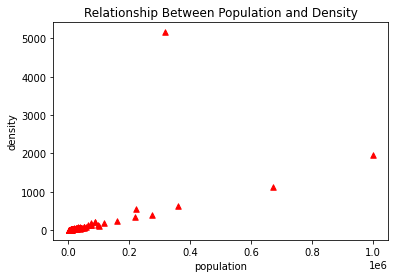

In [30]:
import matplotlib.pyplot as plt
results.plot.scatter(x='population', y='density', s=30, c='red', marker='^')
plt.title('Relationship Between Population and Density')

plt.show()


In [31]:
for index, row in results.iterrows():
    if row['density'] > 1000:
        print(row)

FIPS                        095
county           Jackson County
population               674158
area                        605
location                   1950
start                        38
end                         222
doubling_time           7.46126
density                 1114.31
Name: 47, dtype: object
FIPS                            189
county           Saint Louis County
population                  1000438
area                            508
location                       1998
start                             0
end                               0
doubling_time                   NaN
density                     1969.37
Name: 94, dtype: object
FIPS                          510
county           Saint Louis City
population                 319294
area                         61.9
location                     2017
start                           0
end                             0
doubling_time                 NaN
density                   5158.22
Name: 95, dtype: object


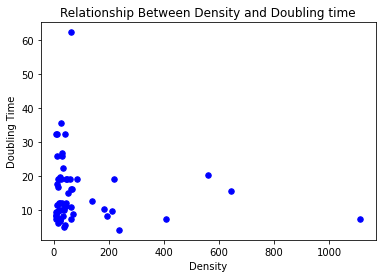

In [32]:
results.plot.scatter(x='density', y='doubling_time', s=30, c='blue')
plt.title('Relationship Between Density and Doubling time')
plt.xlabel('Density')
plt.ylabel('Doubling Time')
plt.show()

In [33]:
for index, row in results.iterrows():
    if row['doubling_time'] > 30:
        print(row)
        

FIPS                       015
county           Benton County
population               19056
area                       706
location                  1910
start                       65
end                         94
doubling_time          35.6995
density                26.9915
Name: 7, dtype: object
FIPS                       023
county           Butler County
population               42794
area                       698
location                  1914
start                       17
end                         21
doubling_time          62.3248
density                61.3095
Name: 11, dtype: object
FIPS                     103
county           Knox County
population              4131
area                     506
location                1954
start                     20
end                       30
doubling_time        32.4807
density              8.16403
Name: 51, dtype: object
FIPS                    177
county           Ray County
population            23494
area                    57

In [34]:
for index, row in results.iterrows():
    if row['density'] > 500:
        print(row)

FIPS                     047
county           Clay County
population            221939
area                     396
location                1926
start                     24
end                       46
doubling_time        20.2429
density              560.452
Name: 23, dtype: object
FIPS                        095
county           Jackson County
population               674158
area                        605
location                   1950
start                        38
end                         222
doubling_time           7.46126
density                 1114.31
Name: 47, dtype: object
FIPS                              183
county           Saint Charles County
population                     360485
area                              561
location                         1994
start                               3
end                                 7
doubling_time                 15.5433
density                       642.576
Name: 91, dtype: object
FIPS                            189
c

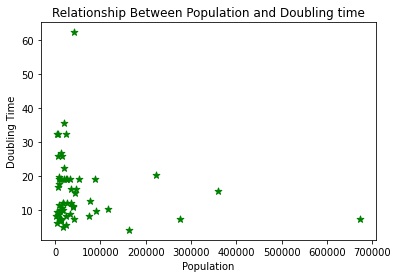

In [35]:
results.plot.scatter(x='population', y='doubling_time', s=50, c='green',  marker='*')
plt.title('Relationship Between Population and Doubling time')
plt.xlabel('Population')
plt.ylabel('Doubling Time')
plt.show()

In [36]:
for index, row in results.iterrows():
    if row['population'] > 200000:
        print(row)

FIPS                     047
county           Clay County
population            221939
area                     396
location                1926
start                     24
end                       46
doubling_time        20.2429
density              560.452
Name: 23, dtype: object
FIPS                       077
county           Greene County
population              275174
area                       675
location                  1941
start                        1
end                          6
doubling_time           7.3502
density                407.665
Name: 38, dtype: object
FIPS                        095
county           Jackson County
population               674158
area                        605
location                   1950
start                        38
end                         222
doubling_time           7.46126
density                 1114.31
Name: 47, dtype: object
FIPS                          099
county           Jefferson County
population                 21873

In [37]:
import seaborn as sns

[None]

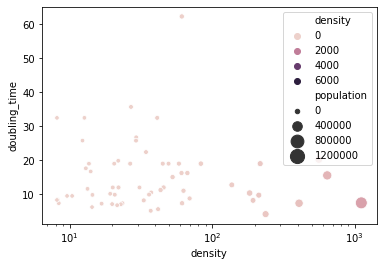

In [38]:
ax = sns.scatterplot(x="density", y="doubling_time",
                     hue="density", size="population",
                     sizes=(20, 200),                      data=results)

ax.set(xscale='log')

